### "Supervisor-Orchestrated Multi-Agent System with LLM-Based Routing".

Architecture Pattern:
1. Supervisor Pattern (Orchestration)
A central supervisor node acts as the orchestrator
It decides which specialized agent should handle each request
After an agent completes its task, control returns to the supervisor
2. LLM-Based Intelligent Routing
Uses structured output (Pydantic model) to make routing decisions
The LLM analyzes user intent and chooses the appropriate agent
More intelligent than keyword-based routing
3. Specialized Agent Nodes
Genie Agent: Handles data/SQL queries (custom agent class)
Search Agent: Handles web searches (tool-based agent)
Each agent is a dedicated node with specific capabilities
4. Stateful with Memory
Uses MessagesState for conversation history
checkpointer enables persistence across sessions
Maintains context through the messages list

###

In [1]:
from typing import Annotated
import sys
import os
from typing_extensions import TypedDict, Literal
from langgraph.graph import MessagesState  # Add this import
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import AzureChatOpenAI
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from langgraph_playground.multiagent_framework.utils import *
from azure.search.documents import SearchClient
from langchain_core.runnables import RunnableConfig
import logging
from langchain_core.tools import tool
import json
from langchain_core.messages import ToolCall
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver
from azure.ai.projects import AIProjectClient
from databricks_langchain.genie import GenieAgent
from databricks.sdk import WorkspaceClient
from databricks_ai_bridge.genie import  Genie, GenieResponse
from operator import add

# Install: pip install -U "psycopg[binary,pool]" langgraph langgraph-checkpoint-postgres

from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.store.postgres import PostgresStore
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig
import uuid
from langmem.short_term import RunningSummary  # Add this import
import psycopg  # Add this import

c:\source\github\gen-ai-prototypes\.venv\Lib\site-packages\pydantic\_internal\_config.py:323: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
c:\source\github\gen-ai-prototypes\.venv\Lib\site-packages\databricks_ai_bridge\vector_search_retriever_tool.py:107: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator("tool_name")
c:\source\github\gen-ai-prototypes\.venv\Lib\site-packages\trustcall\_base.py:46: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constant

In [3]:
# Acquire the logger for this client library. Use 'azure' to affect both
# 'azure.core` and `azure.ai.inference' libraries.
logger = logging.getLogger("azure")

# Set the desired logging level. logging.INFO or logging.DEBUG are good options.
logger.setLevel(logging.DEBUG)

# Direct logging output to stdout:
handler = logging.StreamHandler(stream=sys.stdout)
# Or direct logging output to a file:
# handler = logging.FileHandler(filename="sample.log")
logger.addHandler(handler)

# Optional: change the default logging format. Here we add a timestamp.
#formatter = logging.Formatter("%(asctime)s:%(levelname)s:%(name)s:%(message)s")
#handler.setFormatter(formatter)

# instantiate the checkpoint

checkpointer = InMemorySaver()

# https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/develop/trace-agents-sdk
# https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/develop/langchain

foundry_endpoint = "https://multiagent-governance-resource.services.ai.azure.com/api/projects/multiagent-governance"

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=foundry_endpoint,
    logging_enable=True,
)

No environment configuration found.


2025-11-04 20:46:06,079 - azure.identity._credentials.environment - INFO - No environment configuration found.


ManagedIdentityCredential will use IMDS


2025-11-04 20:46:06,079 - azure.identity._credentials.managed_identity - INFO - ManagedIdentityCredential will use IMDS


In [19]:
application_insights_connection_string = project_client.telemetry.get_application_insights_connection_string()
application_insights_connection_string

'InstrumentationKey=7a4b9ea3-4618-4460-b7f8-97b3c79b9b9f;IngestionEndpoint=https://eastus2-3.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus2.livediagnostics.monitor.azure.com/;ApplicationId=c75662c4-19d5-4b7b-9d52-ea5e39fc35ec'

In [5]:
# Configure tracing for Azure AI Foundry
from langchain_azure_ai.callbacks.tracers import AzureAIOpenTelemetryTracer

azure_tracer = AzureAIOpenTelemetryTracer(
    connection_string=application_insights_connection_string,
    enable_content_recording=True,
    name="genie-multiagent-governance",
)

Skipping instrumentation django: DependencyConflict: requested: "django>=1.10; extra == "instruments"" but found: "None"


2025-11-04 20:46:09,807 - azure.monitor.opentelemetry._configure - DEBUG - Skipping instrumentation django: DependencyConflict: requested: "django>=1.10; extra == "instruments"" but found: "None"


In [6]:
# Create Genie agent
genie_space_id = client.get_secret(name="genie-space-id").value
databricks_host = client.get_secret(name="databricks-host").value
databricks_token = client.get_secret(name="databricks-token").value
ws_client = WorkspaceClient(host=databricks_host, token=databricks_token)
genie_agent = GenieAgent(
    genie_space_id = genie_space_id,
    genie_agent_name = "genie_agent",
    description= "This agent will handle nl-sql questions for the user",
    client = ws_client
)

In [7]:
# Model configuration
# instantiate the chatbot model
model = AzureChatOpenAI(
    model="gpt-4o",
    api_key=azure_openai_api_key,
    api_version="2024-12-01-preview",
    azure_endpoint=azure_openai_endpoint,
    temperature=0.5
)

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Setup Tavily
tavily_api_key = client.get_secret(name="tavilysearch-apikey").value
os.environ["TAVILY_API_KEY"] = tavily_api_key
tavily_tool = TavilySearchResults(max_results=3)

# from langchain_tavily import TavilySearch

# var = "TAVILY_API_KEY"
# tavilysearch_apikey = client.get_secret(name="tavilysearch-apikey").value
# os.environ[var] = tavilysearch_apikey

C:\Users\chchukwu\AppData\Local\Temp\ipykernel_51488\1968096569.py:6: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=3)


In [9]:
tavily_tool

TavilySearchResults(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

In [10]:
# Create the state object

def merge_dicts(existing: dict, new:dict) -> dict:
    """Merge dictionaries, new values override existing ones.
    This enables tracking execution times for multiple agents without
    losing  previous entries"""
    return {**existing, **new}

class AgentState(MessagesState):
    next: Literal["Genie", "Search", "FINISH"]  # Add Search
    user_edits: Annotated[list[dict], add] # Track all user mods
    execution_times: Annotated[dict[str, float], merge_dicts]
    context: dict[str, RunningSummary]  # For summarization

    # Custom fields
    routing_reasoning: Annotated[list[str], add] # Collect routing decisions
    routing_history: list[str] #Track which agent was used
    genie_query_sql: str # Last sql query from Genie
    query_intent: str # Classified intent (SQL, Search, etc)



# Add Summarization node
from langmem.short_term import SummarizationNode
from langchain_core.messages.utils import count_tokens_approximately

# Create summarization node
summarization_node = SummarizationNode(
    token_counter=count_tokens_approximately,
    model=model.bind(max_tokens=128),  # Reuse your existing model
    max_tokens=512,  # Start summarizing after 512 tokens
    max_tokens_before_summary=512,
    max_summary_tokens=128,  # Keep summary under 128 tokens
)

In [11]:
# Genie node with response review
def genie_node(state: AgentState):
    # Execute the query first

    import time
    start_time = time.time()
    response = genie_agent.invoke({"messages": state["messages"]})
    genie_response = response["messages"][-1].content
    execution_time = time.time() - start_time
    
    # Interrupt to let user review and edit the response
    reviewed_response = interrupt({
        "original_response": genie_response,
        "message": "Review Genie's response (press Enter to accept, or edit):"
    })
    
    # Use reviewed response or original if user pressed Enter
    final_response = reviewed_response if reviewed_response else genie_response
    
    return Command(
        update={
        "messages": [{
            "role": "assistant",
            "name": "Genie",
            "content": final_response,
        }],
        "user_edits": [{"agent": "Genie", "edited": bool(reviewed_response)}] if reviewed_response else [],
        "execution_times": {"Genie": execution_time}
    }
    )

# Search node (new)
def search_node(state: AgentState):
    user_query = [m.content for m in state["messages"] if isinstance(m, HumanMessage)][-1]
    results = tavily_tool.invoke({"query": user_query})
    
    if results:
        response = "Search Results:\n\n"
        for idx, result in enumerate(results, 1):
            response += f"{idx}. {result.get('content', '')}\n"
            response += f"   Source: {result.get('url', '')}\n\n"
    else:
        response = "No results found."
    
    return {
        "messages": [{
            "role": "assistant",
            "name": "Search",
            "content": response,
        }]
    }

# Supervisor with LLM-based routing
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel

class RouteDecision(BaseModel):
    agent: Literal["Genie", "Search"]
    reasoning: str

routing_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a routing assistant. Analyze the query and decide which agent should handle it.

Available Agents:
- Genie: SQL queries, data analysis, database questions, business intelligence
- Search: Web searches, current events, general knowledge, research

Choose the most appropriate agent."""),
    ("user", "{query}")
])

routing_chain = routing_prompt | model.with_structured_output(RouteDecision)

def supervisor_node(state: AgentState, config: RunnableConfig, *, store: BaseStore):
    if state["messages"]:
        last_msg = state["messages"][-1]
        sender = getattr(last_msg, "name", None)
        
        # If agent responded, finish
        if sender in ["Genie", "Search"]:
            return {"next": "FINISH"}
        
    # Retrieve memories using semantic search
    user_id = config["configurable"]["user_id"]
    # Sanitize user_id: replace periods and @ with underscores
    sanitized_user_id = user_id.replace(".", "_").replace("@", "_")
    namespace = ("memories", sanitized_user_id)
    user_query = [m.content for m in state["messages"] if isinstance(m, HumanMessage)][-1]
    
    # Search for relevant memories
    memories = store.search(namespace, query=user_query, limit=3)
    memory_context = "\n".join([m.value.get("text", "") for m in memories]) if memories else ""

    # Always store new memory
    memory_id = str(uuid.uuid4())
    store.put(namespace, memory_id, {"text": user_query, "timestamp": str(uuid.uuid1())})
    
    # Use LLM to route
    user_query = [m.content for m in state["messages"] if isinstance(m, HumanMessage)][-1]
    decision = routing_chain.invoke({"query": user_query})
    
    print(f"Routing to {decision.agent}: {decision.reasoning}")
    return Command(
        update={"next": decision.agent}
    )

def select_next_node(state: AgentState) -> str:
    return state["next"]

# Build workflow with supervisor
workflow = StateGraph(AgentState)
workflow.add_node("summarize", summarization_node)  # Add this
workflow.add_node("supervisor", supervisor_node)
workflow.add_node("Genie", genie_node)
workflow.add_node("Search", search_node)
workflow.add_edge(START, "summarize")  # Summarize first
workflow.add_edge("summarize", "supervisor")  # Then route
workflow.add_conditional_edges(
    "supervisor",
    select_next_node,
    {"Genie": "Genie", "Search": "Search", "FINISH": END},
)
workflow.add_edge("Genie", "supervisor")
workflow.add_edge("Search", "supervisor")

In [ ]:
# Initialize Azure OpenAI client
openai_client = AzureOpenAI(
    api_key=azure_openai_api_key,
    api_version="2024-12-01-preview",
    azure_endpoint=azure_openai_endpoint
)

# # Define embedding function
# def embed_function(text: str) -> list[float]:
#     response = openai_client.embeddings.create(
#         input=text,
#         model="text-embedding-3-small"
#     )
#     return response.data[0].embedding

from psycopg.errors import UndefinedTable
DB_URI = client.get_secret(name="comosdb-pgres-connstr-fang").value

import psycopg

ddl_statements = [
    """
    CREATE TABLE IF NOT EXISTS checkpoint_migrations (
        v INTEGER PRIMARY KEY
    );
    """,
    """
    CREATE TABLE IF NOT EXISTS checkpoints (
        thread_id TEXT NOT NULL,
        checkpoint_ns TEXT NOT NULL DEFAULT '',
        checkpoint_id TEXT NOT NULL,
        parent_checkpoint_id TEXT,
        type TEXT,
        checkpoint JSONB NOT NULL,
        metadata JSONB NOT NULL DEFAULT '{}',
        PRIMARY KEY (thread_id, checkpoint_ns, checkpoint_id)
    );
    """,
    """
    CREATE TABLE IF NOT EXISTS checkpoint_blobs (
        thread_id TEXT NOT NULL,
        checkpoint_ns TEXT NOT NULL DEFAULT '',
        channel TEXT NOT NULL,
        version TEXT NOT NULL,
        type TEXT NOT NULL,
        blob BYTEA,
        PRIMARY KEY (thread_id, checkpoint_ns, channel, version)
    );
    """,
    """
    CREATE TABLE IF NOT EXISTS checkpoint_writes (
        thread_id TEXT NOT NULL,
        checkpoint_ns TEXT NOT NULL DEFAULT '',
        checkpoint_id TEXT NOT NULL,
        task_id TEXT NOT NULL,
        task_path TEXT NOT NULL DEFAULT '',
        idx INTEGER NOT NULL,
        channel TEXT NOT NULL,
        type TEXT,
        blob BYTEA NOT NULL,
        PRIMARY KEY (thread_id, checkpoint_ns, checkpoint_id, task_id, idx)
    );
    """,
    "CREATE INDEX IF NOT EXISTS checkpoints_thread_id_idx ON checkpoints(thread_id);",
    "CREATE INDEX IF NOT EXISTS checkpoint_blobs_thread_id_idx ON checkpoint_blobs(thread_id);",
    "CREATE INDEX IF NOT EXISTS checkpoint_writes_thread_id_idx ON checkpoint_writes(thread_id);",
]

with psycopg.connect(DB_URI, autocommit=True) as conn, conn.cursor() as cur:
    for ddl in ddl_statements:
        cur.execute(ddl)
    print("✓ Checkpoint tables created manually")

# Let PostgresSaver record the migration level
from langgraph.checkpoint.postgres import PostgresSaver

with PostgresSaver.from_conn_string(DB_URI) as checkpointer:
    checkpointer.setup()
    print("✓ PostgresSaver migrations registered")


from collections.abc import Sequence
from langgraph.store.postgres.base import PostgresStore as _PostgresStore
import psycopg

class AzurePostgresStore(_PostgresStore):
    VECTOR_MIGRATIONS = tuple(
        migration
        for migration in _PostgresStore.VECTOR_MIGRATIONS
        if "CREATE EXTENSION" not in migration.sql
    )

def ensure_pgvector_available(conn_str: str) -> None:
    with psycopg.connect(conn_str, autocommit=True) as conn, conn.cursor() as cur:
        cur.execute("SELECT 1 FROM pg_extension WHERE extname='vector'")
        if cur.fetchone() is None:
            raise RuntimeError(
                "pgvector is not enabled for this database. Connect as azure_superuser "
                "and run: CREATE EXTENSION vector;"
            )

def embed_function(texts: Sequence[str]) -> list[list[float]]:
    if isinstance(texts, str):
        texts = [texts]
    else:
        texts = list(texts)
    response = openai_client.embeddings.create(
        input=texts,
        model="text-embedding-3-small",
    )
    return [item.embedding for item in response.data]


ensure_pgvector_available(DB_URI)

with AzurePostgresStore.from_conn_string(
    DB_URI,
    index={"embed": embed_function, "dims": 1536},
) as store:
    store.setup()
    print("✓ Store tables created (vector schema present)")

✓ Checkpoint tables created manually
✓ PostgresSaver migrations registered
✓ Store tables created (vector schema present)


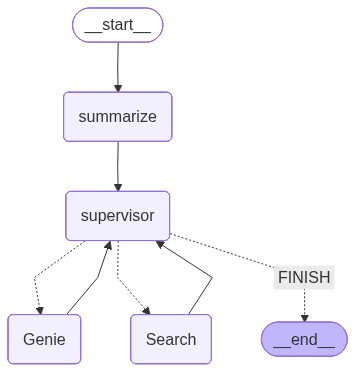

Multi-Agent Chat (Type 'quit' to exit)

Routing to Genie: The query is asking for information about current datasets and the number of tables, which is related to database structure and organization. Genie, being specialized in SQL queries and database questions, is the most suitable agent to handle this request.

Review Genie's response (press Enter to accept, or edit):

Original response:
There are currently 8 tables available in the datasets. The tables cover New York City taxi trips and the TPCH benchmark schema, including customer, orders, lineitem, part, partsupp, supplier, and nation tables.

Enter edited response (or press Enter to accept):

Final Response:
restrict the insights to 4 tables

⏱️  Genie: 2.16s

Ending chat.


In [18]:
# define the Runnable config object with user_id and thread_id

with (
    PostgresSaver.from_conn_string(DB_URI) as checkpointer,
    AzurePostgresStore.from_conn_string(
        DB_URI,
        index={"embed": embed_function, "dims": 1536},
    ) as store,
):
    graph = workflow.compile(checkpointer=checkpointer, store=store)

    # Visualize the graph
    from IPython.display import Image, display

    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

    user_id = "charlesc@partnergem.com"
    config = {"configurable": {"thread_id": "1", "user_id": user_id}, "callbacks": [azure_tracer]}

    # Chat function with response review support
    def chat_with_genie_hitl():
        """Chat with review-and-edit support for Genie responses"""
        print("Multi-Agent Chat (Type 'quit' to exit)\n")
        
        while True:
            user_input = input("You: ").strip()
            
            if user_input.lower() in {"quit", "exit", "q"}:
                print("Ending chat.")
                break
            
            payload = {"messages": [{"role": "user", "content": user_input}]}
            result = graph.invoke(payload, config=config)
            
            # Handle interrupt if present
            while "__interrupt__" in result:
                interrupt_data = result["__interrupt__"][0].value
                
                print(f"\n{interrupt_data['message']}")
                print(f"\nOriginal response:\n{interrupt_data['original_response']}\n")
                
                # Get user's edit or keep original
                print("Enter edited response (or press Enter to accept):")
                edited = input().strip()
                resume_value = edited if edited else interrupt_data['original_response']
                
                # Resume with the response (edited or original)
                result = graph.invoke(Command(resume=resume_value), config=config)
            
            # Display final response
            ai_messages = [msg.content for msg in result["messages"] if isinstance(msg, AIMessage)]
            if ai_messages:
                print(f"\nFinal Response:\n{ai_messages[-1]}\n")

            # Print routing reason and execution times
            reasoning = result.get("routing_reasoning", [])
            exec_times = result.get("execution_times", {})

            if exec_times:
                agent = list(exec_times.keys())[-1]
                duration = exec_times[agent]
                print(f"⏱️  {agent}: {duration:.2f}s")

            if reasoning:
                print(f"🔀 Reason: {reasoning[-1]}")

            # Show summary if available
            if "context" in result and "running_summary" in result["context"]:
                summary = result["context"]["running_summary"].summary
                if summary:
                    print(f"📝 Summary: {summary[:100]}...")
            
            print()  # Empty line for spacing

    chat_with_genie_hitl()